In [1]:
# import os
from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize
# from nltk.stem import PorterStemmer
from collections import Counter
# from num2words import num2words
# from nltk.util import bigrams
# from nltk.probability import FreqDist
import spacy # spaCy for preprocessing
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import re
# import nltk
import txtFuncts as tfs
# from wordcloud import WordCloud

import gensim # Gensim for Topic Modeling"
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis.gensim_models
# from wordcloud import STOPWORDS, ImageColorGenerator

## Reading and Cleaning

In [2]:
corpus=tfs.readCorpus('Articles')

[====================>] 100%


In [3]:
cleanCorpus=[]
for doc in corpus:
    openInds=[]
    closeInds=[]

    # Find indices of the regular expressions
    opens=re.finditer("\nDocument.+[a-z0-9]",doc)
    closes=re.finditer("[aA]ll [rR]ights [rR]eserved",doc)
    cleanDoc=''
    for i in opens:
        openInds.append(i.span())
    for i in closes:
        closeInds.append(i.span())

    # Use the expressions to extract data and exclude metadata
    i,j=0,0
    while i<len(closeInds):
        start=closeInds[i][1]+1
        
        while openInds[j][0]<start:
            j+=1
        end=openInds[j][0]-1
        cleanDoc+=doc[start:end]+' '
        i+=1
        j+=1

    cleanDoc=re.sub(r"\(PHOTOGRAPHS BY [A-Z\W? ?]*\)",' ',cleanDoc)

    cleanCorpus.append(cleanDoc)

for i in range(len(cleanCorpus)):
    cleanCorpus[i]=cleanCorpus[i].replace('\n',' ')

In [218]:
data,tokens=tfs.preprocessText(cleanCorpus,stem=True)
topk=tfs.getkMostUsed(data,30)

data2,tokens2=tfs.preprocessText(cleanCorpus,stem=True,removeStop=True)
topk2=tfs.getkMostUsed(data2,30)

data3,tokens3=tfs.preprocessText(cleanCorpus,stem=False,removeStop=True)
topk3=tfs.getkMostUsed(data3,30)

[====================>] 100%
[====================>] 100%
[====================>] 100%


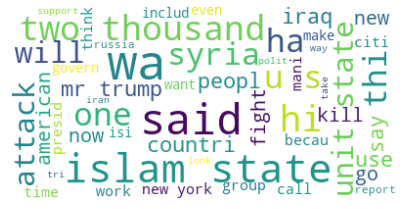

In [219]:
wordcloud=tfs.genWordCloud(data,50)
plt.figure(figsize=(7,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

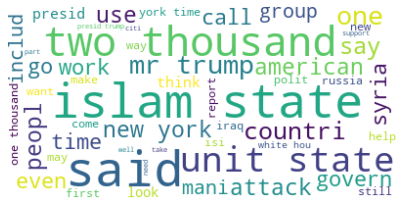

In [220]:
wordcloud=tfs.genWordCloud(data2,50)
plt.figure(figsize=(7,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

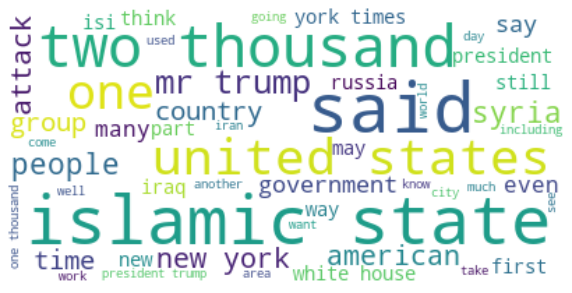

In [269]:
wordcloud=tfs.genWordCloud(data3,50)
plt.figure(figsize=(10,9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

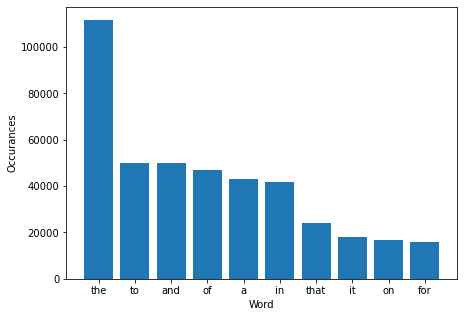

In [222]:
tfs.plotTopk(topk,10)

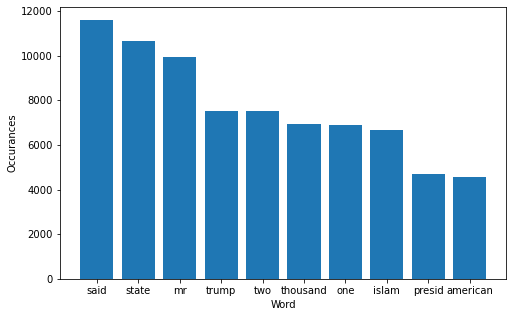

In [267]:
tfs.plotTopk(topk2,10,fwidth=8)

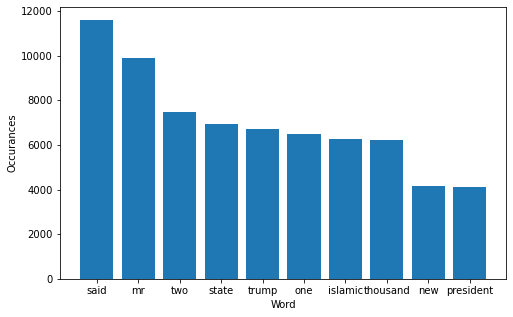

In [270]:
tfs.plotTopk(topk3,10,fwidth=8)

In [225]:
bigrams=tfs.topkBigrams(tokens3,100)

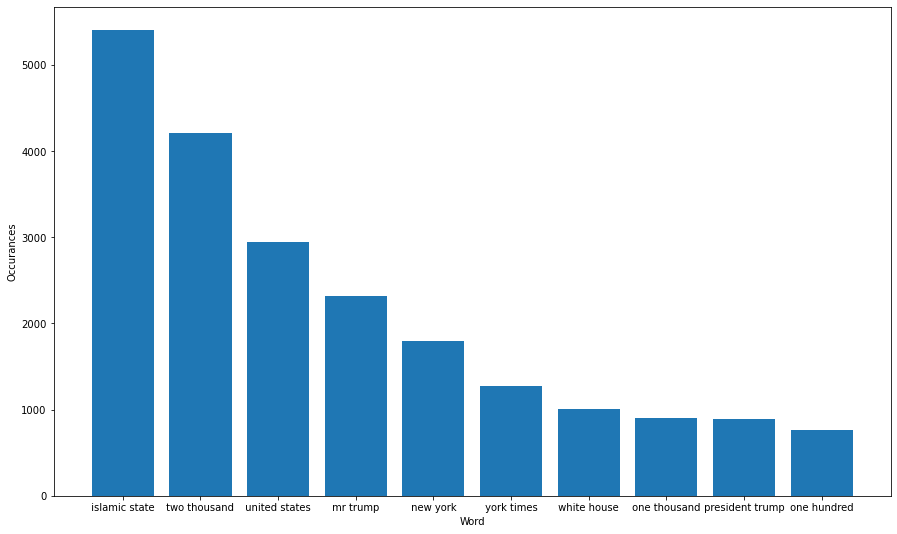

In [278]:
tfs.plotTopk(bigrams,10,fwidth=15,fheight=9)

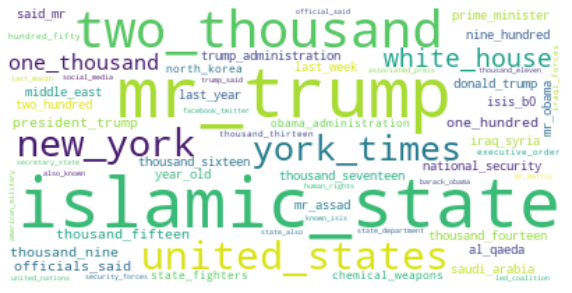

In [259]:
wordcloud=tfs.genWordCloud(bigrams,60,bigrams=True)
plt.figure(figsize=(10,9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [4]:
data4,tokens4=tfs.preprocessText(cleanCorpus,stem=False,removeStop=True,extraWords=['mew york times','thousand','said'])
topk4=tfs.getkMostUsed(data4,30)

[====================>] 100%


In [10]:
c=0
for doc in tokens4:
    for word in doc:
        if word=='said':
            c+=1
print(c)

0


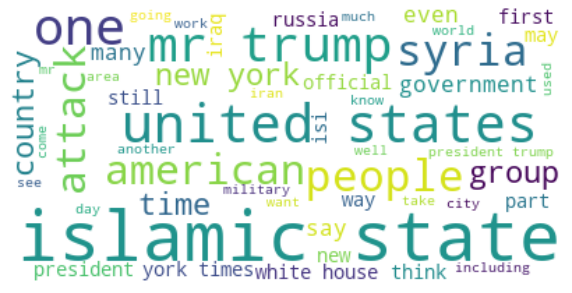

In [11]:
wordcloud=tfs.genWordCloud(data4,50)
plt.figure(figsize=(10,9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

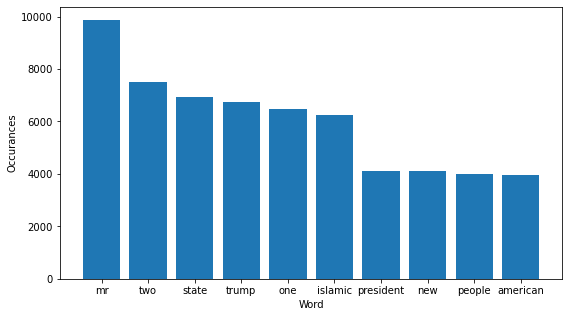

In [12]:
tfs.plotTopk(topk4,10,fwidth=9)

In [13]:
bigrams2=tfs.topkBigrams(tokens4,100)

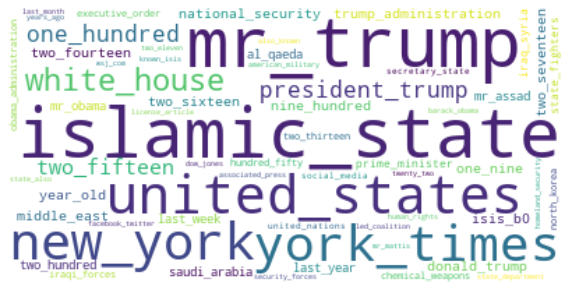

In [14]:
wordcloud=tfs.genWordCloud(bigrams2,60,bigrams=True)
plt.figure(figsize=(10,9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [4]:
data5,tokens5=tfs.preprocessText(cleanCorpus,stem=False,removeStop=False)

[====================>] 100%


In [5]:
bigram=gensim.models.Phrases(tokens5, min_count=5, threshold=100) # higher threshold fewer phrases.
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [28]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['said'])

In [29]:
# Define function for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

# def make_trigrams(texts):
#     return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [30]:
# Remove Stop Words
data_words_nostops = remove_stopwords(tokens5)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# !python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


In [31]:
# Create Dictionary 
id2word = corpora.Dictionary(data_lemmatized)  
# Create Corpus 
texts = data_lemmatized  
# Term Document Frequency 
corpus = [id2word.doc2bow(text) for text in texts]  

In [32]:
perps=[]
coh=[]
ntops=list(range(2,21))
for n in ntops:
    # Build LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=n, 
                                            random_state=100,
                                            update_every=10,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)
    # Compute Perplexity
    perps.append(lda_model.log_perplexity(corpus))  
    # a measure of how good the model is. lower the better.
    # Compute Coherence Score

    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coh.append(coherence_lda)
    tfs.print_progress(n,ntops[-1])

[====================>] 100%


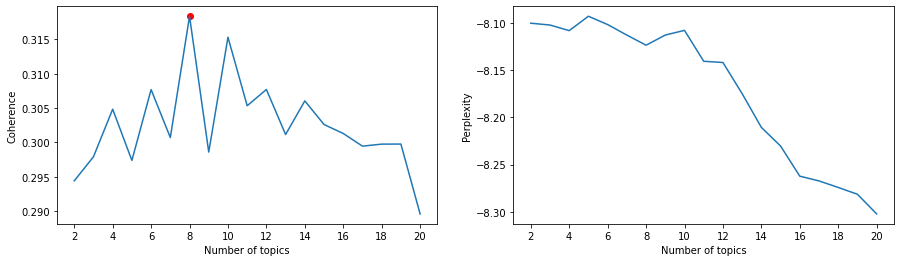

In [38]:
fig,axs=plt.subplots(nrows=1,ncols=2,figsize=(15, 4))

axs[0].plot(ntops,coh)
axs[0].set_xlabel('Number of topics')
axs[0].set_ylabel('Coherence')
axs[0].set_xticks(ntops[::2])
axs[0].scatter(8,coh[6],color='red')

axs[1].plot(ntops,perps)
axs[1].set_xlabel('Number of topics')
axs[1].set_ylabel('Perplexity')
axs[1].set_xticks(ntops[::2])
plt.show()

In [50]:
maxcoh=0
bestseed=0
for i in range(0,101,10):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=id2word,
                                                num_topics=8, 
                                                random_state=i,
                                                update_every=5,
                                                chunksize=100,
                                                passes=10,
                                                alpha='auto',
                                                per_word_topics=True)

    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    if coherence_lda>maxcoh:
        maxcoh=coherence_lda
        bestseed=i
    tfs.print_progress(i,100)

[====================>] 100%


In [56]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=8, 
                                            random_state=100,
                                            update_every=10,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)

In [42]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.006*"state" + 0.006*"people" + 0.005*"go" + 0.005*"islamic" + '
  '0.005*"attack" + 0.005*"year" + 0.004*"take" + 0.004*"isis" + 0.004*"also" '
  '+ 0.004*"think"'),
 (1,
  '0.007*"state" + 0.006*"islamic" + 0.005*"people" + 0.004*"attack" + '
  '0.004*"go" + 0.004*"isis" + 0.004*"take" + 0.004*"make" + 0.004*"year" + '
  '0.004*"force"'),
 (2,
  '0.013*"state" + 0.010*"islamic" + 0.007*"force" + 0.006*"group" + '
  '0.006*"iraqi" + 0.005*"official" + 0.005*"year" + 0.005*"say" + '
  '0.005*"government" + 0.005*"attack"'),
 (3,
  '0.009*"state" + 0.008*"s" + 0.007*"military" + 0.007*"go" + '
  '0.007*"official" + 0.007*"gigot" + 0.007*"think" + 0.006*"islamic" + '
  '0.006*"force" + 0.006*"syrian"'),
 (4,
  '0.009*"trump" + 0.007*"military" + 0.006*"attack" + 0.005*"state" + '
  '0.005*"american" + 0.005*"use" + 0.005*"people" + 0.005*"also" + '
  '0.004*"year" + 0.004*"think"'),
 (5,
  '0.006*"state" + 0.006*"trump" + 0.006*"people" + 0.005*"islamic" + '
  '0.004*"united_sta

In [57]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.019579 -0.009016       1        1  20.903164
7      0.032037 -0.010793       2        1  20.888548
5      0.018596  0.002862       3        1  20.315654
1      0.014739 -0.017468       4        1  16.728290
3      0.065200  0.014935       5        1   8.991832
2      0.023745 -0.050496       6        1   7.263141
4      0.005521  0.073034       7        1   4.909324
6     -0.179416 -0.003058       8        1   0.000046, topic_info=                Term         Freq        Total Category  logprob  loglift
1507           state  6024.000000  6024.000000  Default  30.0000  30.0000
133           attack  3721.000000  3721.000000  Default  29.0000  29.0000
1639           trump  3438.000000  3438.000000  Default  28.0000  28.0000
819          islamic  4753.000000  4753.000000  Default  27.0000  27.0000
1123          people  3881.000000  3881.000000  Default  26.0000  26.0000
...              ...          ...          ...      ...      ...      ...
34    administration     0.000249  1579.443522   Topic8  -7.2378  -1.0719
862             last     0.000285  2266.470878   Topic8  -7.1014  -1.2967
1570            take     0.000307  2947.079070   Topic8  -7.0273  -1.4852
677              get     0.000279  2289.538538   Topic8  -7.1254  -1.3308
371          country     0.000280  2779.565169   Topic8  -7.1209  -1.5202

[686 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
18026      2  0.043067     abballa
18026      7  0.904406     abballa
23382      1  0.918369    abdeslam
24082      5  0.920499  abdication
1778       1  0.896459     abraham
...      ...       ...         ...
1764       3  0.205473        year
1764       4  0.152859        year
1764       5  0.098378        year
1764       6  0.082812        year
1764       7  0.050746        year

[1495 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 8, 6, 2, 4, 3, 5, 7])